# WET-007: Compare CWFS approaches with WET-001 ComCam data

Last Verified to Run: **2024-11-08** <br>
Software Version:
  - `ts_wep`: **12.5.0**
  - `lsst_distrib`: **w_2024_45**

In this document we compare the wavefront estimation between using TIE and Danish using simulated WET-001 ComCam data.  As for LsstCam (see [SITCOMTN-144](https://sitcomtn-144.lsst.io/)),  each extra/intra/in-focus triplet is simulated for 100 random optical states.  The defocal offset of R22 is achieved by moving a piston by +/-1.5mm. 

## Imports 

In [2]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
import numpy as np
from lsst.obs.lsst import LsstComCam
from lsst.ts.wep.task.generateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig)
from copy import copy
from astropy.visualization import ZScaleInterval
from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import (
CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig
)


## Employ the central butler repository  to ingest raws,  perform ISR, and run WEP.

    butler register-instrument /sdf/data/rubin/repo/aos_imsim lsst.obs.lsst.LsstComCam 
    
    butler ingest-raws /sdf/data/rubin/repo/aos_imsim/ /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state_*/amp* --update-records -t direct
    
    butler write-curated-calibrations /sdf/data/rubin/repo/aos_imsim  lsst.obs.lsst.LsstComCam 
    
    butler define-visits /sdf/data/rubin/repo/aos_imsim   lsst.obs.lsst.LsstComCam


In   `/sdf/group/rubin/shared/scichris/DM-46763_WET-007`,  make `site_bps.yaml`, containing  


    site:
      s3df:
        profile:
          condor:
            +Walltime: 7200

In [2]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTComCam/raw/all'],
                             where=f"instrument='LSSTComCam' and visit.day_obs = 20240723 and exposure.science_program = '1'").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)

2640


We're short of 9x300 = 2700, because for some optical states not all detectors got simulated. 

Run ISR on all states:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007

    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:commissioning


    description: basic ISR
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstComCam
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        # Below we specify the configuration settings we want to use
        # when running the task in this pipeline. Since our data doesn't
        # include bias or flats we only want to use doApplyGains and
        # doOverscan in our isr task.
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: True
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'

      
    
    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim -i  LSSTComCam/raw/all,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_ISR -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineISR.yaml  -d "instrument='LSSTComCam' and exposure.science_program = '1'"


In [54]:
collection = 'WET-001_lsstComCam_ISR'
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=[collection],
                             where=f"instrument='LSSTComCam' and exposure.day_obs = 20240723").expanded()
print(len(list(dataRefs)))

2640


Find all intra and extra-focal exposure ids corresponding to a particular state:

In [64]:
for ref in list(dataRefs):
    seq_num = int(str(ref.dataId.exposure.seq_num)[1:])
    
    # for N-th state, the extra states 
    # have seqNum of 2N-1,  intra states have 2N
    state = seq_num // 2 
    defocus = str(ref.dataId.exposure.seq_num)[0] # 5 for in-focus,  6 for defocal 
    
    raft = ref.dataId.detector.id
    if defocus == '6' and state == 4:
        print(state, seq_num, raft, ref.dataId.exposure.id)

4 9 3 5024072306009
4 9 6 5024072306009
4 8 4 5024072306008
4 9 5 5024072306009
4 8 0 5024072306008
4 9 2 5024072306009
4 8 6 5024072306008
4 8 5 5024072306008
4 8 7 5024072306008
4 8 8 5024072306008
4 9 7 5024072306009
4 9 4 5024072306009
4 8 3 5024072306008
4 8 2 5024072306008
4 9 1 5024072306009
4 8 1 5024072306008
4 9 8 5024072306009
4 9 0 5024072306009


## Choosing the maximum number of Zernike terms 

We find that there is a difference in fit results depending on tha maximum number of Zernike terms used. This means we're fitting `Zk4`: `ZkN`. The default `N` for a long time was Zk22. For imSim the default of OPD header was up to `Zk29`, which motivated the change in `ts_wep` defaults, and introduction  of `maxNollIndex` parameter in `estimateZernikes`. To illustrate the point we run interactive steps of a  pipeline for a single detector pair. 

First, donut detection and cutouts:

In [65]:
dataIdIntra = {'instrument': 'LSSTComCam', 'detector': 0, 'exposure': 5024072306008, 'day_obs': 20240723, } # 2N 
dataIdExtra = {'instrument': 'LSSTComCam', 'detector': 0, 'exposure': 5024072306007, 'day_obs': 20240723, } # 2N-1

collection = 'WET-001_lsstComCam_ISR'
exposureIntra = butler.get('postISRCCD', dataId=dataIdIntra, collections=[collection])
exposureExtra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[collection]) 

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 159 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 159 of 159 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 46/159 references


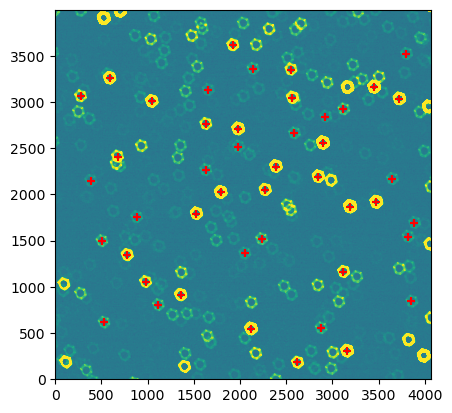

In [71]:

config = GenerateDonutDirectDetectTaskConfig()
config.measurementTask.nSigmaDetection = 5
config.donutSelector.useCustomMagLimit = True

camera = LsstComCam().getCamera()

task = GenerateDonutDirectDetectTask(config=config)
taskOut = task.run(copy(exposureIntra), camera)

# plot the exposure and detected donuts
fig = plt.figure()

d = exposureIntra.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(d)
plt.imshow(d, vmin=vmin, vmax=vmax, origin='lower')
plt.scatter(taskOut.donutCatalog['centroid_x'], taskOut.donutCatalog['centroid_y'], 
            marker='+', c='r', label=f'doDonutSelection:{config.doDonutSelection}'
                )

That's a sufficient number of donuts to compare wavefront retrieval as a function of `maxNollIndex`. Prepare cutouts:

In [74]:
config = CutOutDonutsScienceSensorTaskConfig()
task = CutOutDonutsScienceSensorTask(config=config)

In [76]:
taskOut = task.run([exposureIntra, exposureExtra],
                   [taskOut.donutCatalog,taskOut.donutCatalog],
                   camera
                  )

INFO:lsst.CutOutDonutsScienceSensorTask:Median Recentering Shift: (3.0, 4.0)
INFO:lsst.CutOutDonutsScienceSensorTask:Median Recentering Shift: (1.0, 1.0)


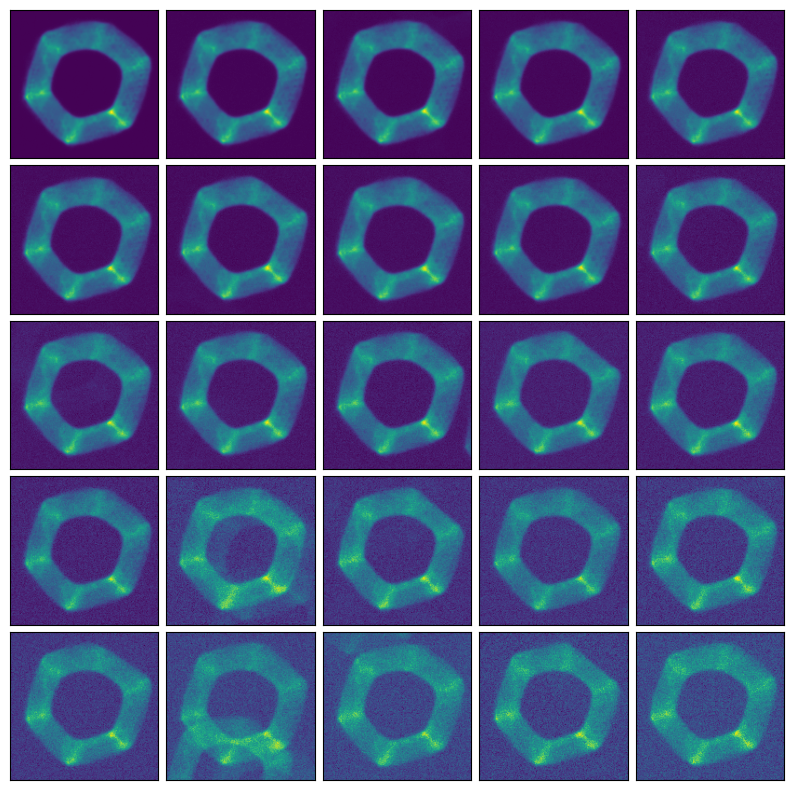

In [77]:
# illustrate the donuts 
fig,axs = plt.subplots(5,5, figsize=(10,10))
ax = np.ravel(axs)
i=0
donutStamps = taskOut.donutStampsExtra
for stamp in donutStamps:
    if i < len(ax):
        ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        i += 1 
fig.subplots_adjust(hspace=0.05, wspace=0.05)

if len(donutStamps)<len(ax):
    for i in range(len(donutStamps), len(ax)):
        ax[i].axis('off')

In [ ]:
# run TIE and Danish fit, store the intermediate results for plotting
from lsst.ts.wep.task.calcZernikesTask import ( CalcZernikesTask, CalcZernikesTaskConfig )
from lsst.ts.wep.task import EstimateZernikesTieTask
from lsst.ts.wep.task import EstimateZernikesDanishTask
state = 4 
raft = 0
config = CalcZernikesTaskConfig()
config.estimateZernikes.retarget(EstimateZernikesTieTask)
#config.estimateZernikes.retarget(EstimateZernikesDanishTask)
tieOutput = {}
for maxNoll in range(22,29):
    config.estimateZernikes.maxNollIndex = maxNoll
    task = CalcZernikesTask(config=config)
    taskOut = task.run( donutStampsExtra, donutStampsIntra)
    tieOutput[maxNoll] = taskOut
tieFile  = f'DM-46763_WET-001_lsstComCam_state{state}_det{raft}_tie'
np.save(tieFile, tieOutput)

In [ ]:
from lsst.ts.wep.task.calcZernikesTask import ( CalcZernikesTask, CalcZernikesTaskConfig )
from lsst.ts.wep.task import EstimateZernikesTieTask
from lsst.ts.wep.task import EstimateZernikesDanishTask

config = CalcZernikesTaskConfig()
config.estimateZernikes.retarget(EstimateZernikesDanishTask)
danishOutput = {}
for maxNoll in range(22,29):
    config.estimateZernikes.maxNollIndex = maxNoll
    task = CalcZernikesTask(config=config)
    taskOut = task.run( donutStampsExtra, donutStampsIntra)
    danishOutput[maxNoll] = taskOut
danishFile = f'DM-46763_WET-001_lsstComCam_state{state}_det{raft}_danish'

In [ ]:
np.save(danishFile, danishOutput)

First plot the fit results for Danish - note that the result does not depend much on the `maxNollIndex` fitted. In the figuere below the errorbars correspond to the standard deviation of the fitted Zernikes.

In [85]:
if os.path.exists(danishFile):
    danishOutput = np.load(danishFile, allow_pickle=True).item()

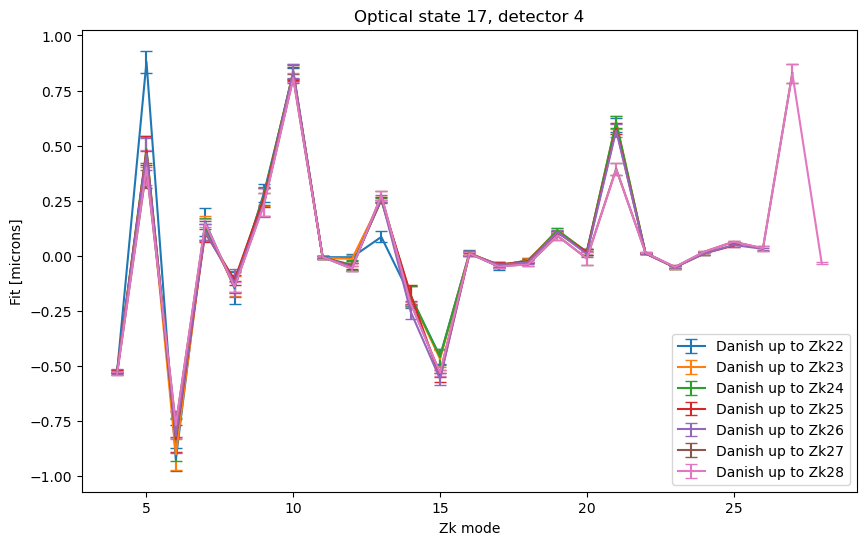

In [88]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
for maxNoll in range(22,29):
    taskOut = danishOutput[maxNoll]
    zkr = taskOut.outputZernikesRaw
    zka = taskOut.outputZernikesAvg
    zks = taskOut.zernikes
    mask_used = zks['used'][1:]
    zkr_used = zkr[mask_used]
    ax.errorbar(np.arange(4, maxNoll+1), zka[0], yerr=np.std(zkr_used, axis=0), label=f"Danish up to Zk{maxNoll}", capsize=4)
  

ax.set_xlabel('Zk mode')
ax.set_ylabel('Fit [microns]')
ax.set_title(f'Optical state {state}, detector {raft}')
ax.legend()

For TIE the situation is vastly different - we obtain similar results  only up to `maxNollIndex` of 26. 

In [90]:
if os.path.exists(tieFile):
    tieOutput = np.load(tieFile, allow_pickle=True).item()

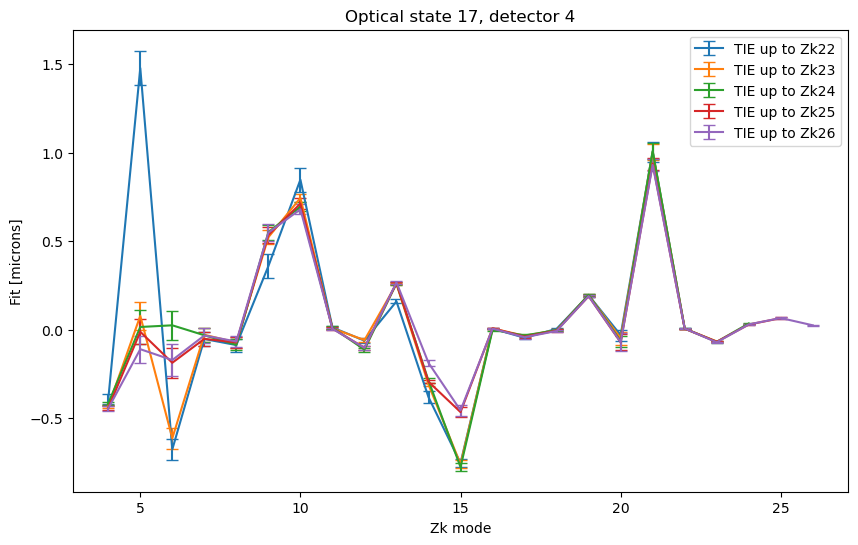

In [91]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
for maxNoll in range(22,27):# tieOutput.keys():
    taskOut = tieOutput[maxNoll]
    zkr = taskOut.outputZernikesRaw
    zka = taskOut.outputZernikesAvg
    zks = taskOut.zernikes
    mask_used = zks['used'][1:]
    zkr_used = zkr[mask_used]

    ax.errorbar(np.arange(4, maxNoll+1), zka[0], 
                yerr=np.std(zkr_used, axis=0), 
                label=f"TIE up to Zk{maxNoll}", capsize=4)

ax.set_xlabel('Zk mode')
ax.set_ylabel('Fit [microns]')
ax.set_title(f'Optical state {state}, detector {raft}')
ax.legend()

For `maxNollIndex` between 27-29, the situation becomes more unconstrained. In both plots we include the results with `maxNollIndex` set to 26 for reference:

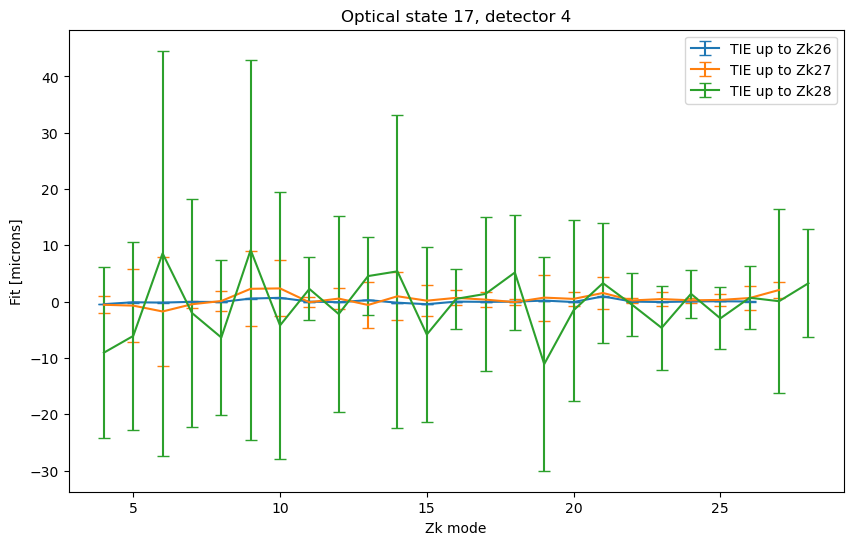

In [92]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
for maxNoll in range(26,29):
    taskOut = tieOutput[maxNoll]
    zkr = taskOut.outputZernikesRaw
    zka = taskOut.outputZernikesAvg
    zks = taskOut.zernikes
    mask_used = zks['used'][1:]
    zkr_used = zkr[mask_used]
    ax.errorbar(np.arange(4, maxNoll+1), zka[0], 
                yerr=np.std(zkr_used, axis=0), 
                label=f"TIE up to Zk{maxNoll}", capsize=4)

ax.set_xlabel('Zk mode')
ax.set_ylabel('Fit [microns]')
ax.set_title(f'Optical state {state}, detector {raft}')
ax.legend()

Given that, we run WEP pipeline with `maxNollIndex` set to 29 (current default) and to 22 (previous default), especially given how it affects the fit results. 

## Run the WEP pipeline with bps

We use the following pipelines yamls

* TIE pipeline (`lsstComCamPipelineDonutsZernikesTIE.yaml`)

        description: run pipeline from ISR to Zk with TIE
        
        # Here we specify the corresponding instrument for the data we
        # will be using.
        instrument: lsst.obs.lsst.LsstComCam
        
        # Then we can specify each task in our pipeline by a name
        # and then specify the class name corresponding to that task
        tasks:
          generateDonutDirectDetectTask:
            class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
            config:
              donutSelector.useCustomMagLimit: True
              measurementTask.nSigmaDetection: 5
          cutOutDonutsScienceSensorGroupTask::
            class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
          calcZernikesTask:
            class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
            config:
              estimateZernikes.maxNollIndex: 29



* Danish pipeline (`lsstComCamPipelineDonutsZernikesDanish.yaml`):

    
        description: run pipeline from ISR to Zk with Danish
        
        # Here we specify the corresponding instrument for the data we
        # will be using.
        instrument: lsst.obs.lsst.LsstComCam
        
        # Then we can specify each task in our pipeline by a name
        # and then specify the class name corresponding to that task
        tasks:
          generateDonutDirectDetectTask:
            class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
            config:
              donutSelector.useCustomMagLimit: True
              measurementTask.nSigmaDetection: 5
          cutOutDonutsScienceSensorTask::
            class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
          calcZernikesTask:
            class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
            config:
               estimateZernikes.maxNollIndex: 29
               python: |
                  from lsst.ts.wep.task import EstimateZernikesTieTask, EstimateZernikesDanishTask
                  config.estimateZernikes.retarget(EstimateZernikesDanishTask)

They are run with following commands: 

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007/
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:commissioning

   
    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_TIE_6001_6200_bps  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesTIE.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723" 

    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_Danish_6001_6200_bps  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesDanish.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723"

After changing `estimateZernikes.maxNollIndex` to `22` we run as: 

    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_TIE_6001_6200_bps_zk22  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesTIE.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723" 
    
    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_Danish_6001_6200_bps_zk22  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesDanish.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723"


## Inspect the results 

Plot the comparison in fit results between Danish and TIE:

In [15]:
fname = f'DM-46763_WET-001_lsstComCam_tie_danish_maxNollIndex_{maxNollIndex}.npy'
os.path.exists(fname)


True

In [17]:
# store all Danish vs TIE in a dictionary 
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
results_stored = {}
for maxNollIndex in  [22,29]:

    coll = '_zk22' if maxNollIndex == 22 else ''
    fname = f'DM-46763_WET-001_lsstComCam_tie_danish_maxNollIndex_{maxNollIndex}.npy'
    if os.path.exists(fname):
        results_stored[maxNollIndex] =  np.load( fname, allow_pickle=True).item()
        print(f'Reading from {fname}')
    else:
        results = {'tie':{}, 'danish':{}}
        for method in results.keys():
            coll_method = 'TIE' if method == 'tie' else 'Danish'
            results[method] = {}
            output_collection = f'WET-001_lsstComCam_{coll_method}_6001_6200_bps{coll}'
       
            # get the available refs 
            datasetRefs = list(registry.queryDatasets('zernikeEstimateAvg', collections=[output_collection],
                                             ).expanded())
            seqs = np.array([int(str(ref.dataId.visit.seq_num)[1:]) for ref in datasetRefs])
            states = np.unique(np.array((seqs+1) / 2).astype(int) )
            for state in states:
                results[method][state] = {}
                for raft in range(9):
                    results[method][state][raft] = {}
                    
            for ref in datasetRefs:
            # read in the results of each method 
    
                seq_num = int(str(ref.dataId.visit.seq_num)[1:])
                state = int((seq_num+1)/2)
                raft = ref.dataId.detector.id
                results[method][state][raft]['zernikeEstimateAvg'] =  butler.get('zernikeEstimateAvg', 
                                  dataId=ref.dataId, 
                                  collections=[output_collection])
                results[method][state][raft]['zernikeEstimateRaw'] =  butler.get('zernikeEstimateRaw', 
                                  dataId=ref.dataId, 
                                  collections=[output_collection])
                results[method][state][raft]['zernikes'] =  butler.get('zernikes', 
                                  dataId=ref.dataId, 
                                  collections=[output_collection])
                results[method][state][raft]['dataId'] = ref.dataId
        results_stored[maxNollIndex] = results
        print(f'Saving {fname}')
        np.save(fname, results, )

Reading from DM-46763_WET-001_lsstComCam_tie_danish_maxNollIndex_22.npy
Reading from DM-46763_WET-001_lsstComCam_tie_danish_maxNollIndex_29.npy


To compare TIE vs Danish, we first plot the actual fit results for each detector for a single optical state:

In [19]:
def plot_fit(state, results, title=''):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        
        ax[i].set_title(i)
        detId = i 
        for method in results.keys():
            # plot  averaged zks for danish and tie
            zkAvg = results[method][state][detId]['zernikeEstimateAvg'][0]
            minNoll = 4
            maxNoll = minNoll + len(zkAvg)
            ax[i].plot(np.arange(minNoll,maxNoll), zkAvg, marker='d', label=f'{method} ')
          
        ax[i].set_xticks(np.arange(minNoll,maxNoll,step=2))
        ax[i].axhline(0,ls='--', c='red')
        ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    if title == '' :
      title = f'WET-007 comCam, state {state}, \n : TIE vs Danish'
    fig.suptitle(title)

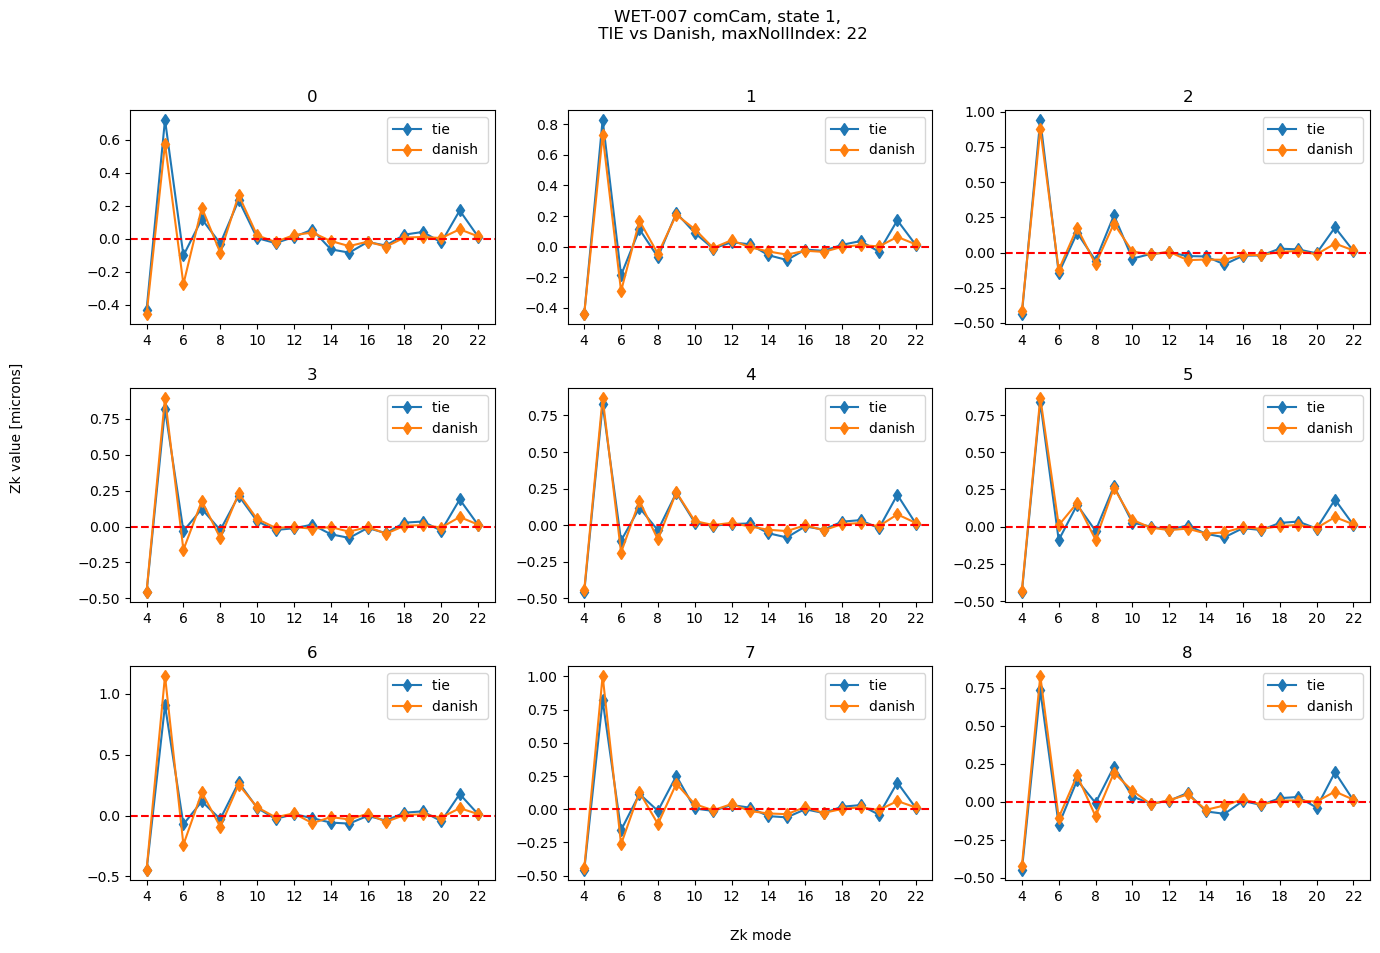

In [20]:
state=1
maxNollIndex=22
plot_fit(state, results_stored[maxNollIndex], title=f'WET-007 comCam, state {state}, \n TIE vs Danish, maxNollIndex: {maxNollIndex}')

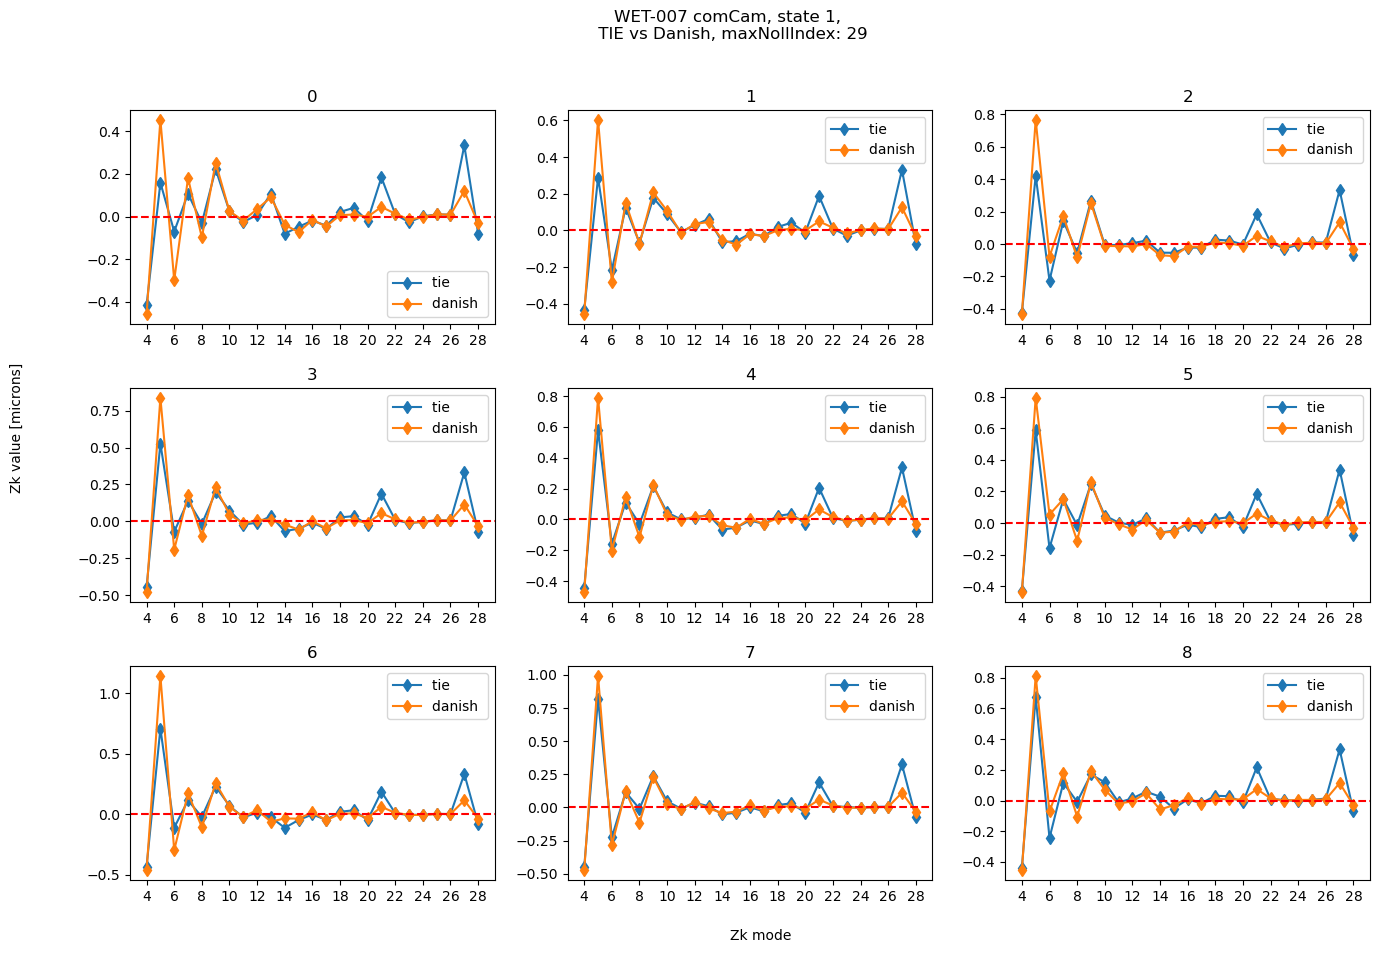

In [21]:
state=1
maxNollIndex=29
plot_fit(state,  results_stored[maxNollIndex], title=f'WET-007 comCam, state {state}, \n TIE vs Danish, maxNollIndex: {maxNollIndex}')

Add information about the uncertainty in Zernike estimation. This could be either:
* standard deviation of raw Zernike estimates per detector that went into per-detector average (sample N = number of donut pairs in each detector)
* standard deviation of averaged Zernikes across all detectors (sample N=9, corresponding to the number of detectors)

Illustrate both  methods. In the figure below the left panel shows the average result with solid green line, and the individual estimates per donut pair in light gray. The errorbars correspond here to the standard deviation of the scatter per mode. The right panel illustrates the average across all detectors, and uncertainty is the scatter in those estimates. 


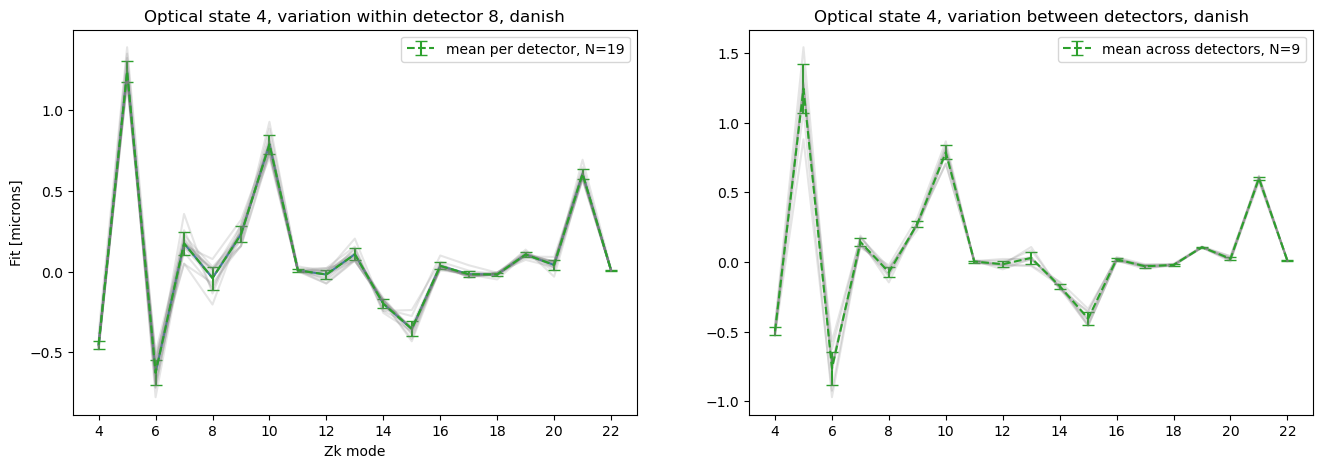

In [24]:
method = 'danish'
state = 4
raft = 8
maxNollIndex = 22
zkr =  results_stored[maxNollIndex][method][state][raft]['zernikeEstimateRaw']
zka =  results_stored[maxNollIndex][method][state][raft]['zernikeEstimateAvg'][0]
zks =  results_stored[maxNollIndex][method][state][raft]['zernikes']

mask_used = zks['used'][1:]
zkr_used = zkr[mask_used]


zka_dets = []
for det in range(9):
    zka_dets.append( results_stored[maxNollIndex][method][state][det]['zernikeEstimateAvg'][0])
    
minNoll = 4
maxNoll = minNoll + len(zka)

fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(np.arange(minNoll, maxNoll), zka)
Npts = len(zkr)
ax[0].errorbar(np.arange(minNoll, maxNoll), zka, yerr=np.std(zkr_used, axis=0), ls="--", c="C2", 
               label=f"mean per detector, N={Npts}", capsize=4)
for i in range(len(zkr_used)):
    ax[0].plot(np.arange(minNoll, maxNoll), zkr_used[i], alpha=0.2,c='grey')
ax[0].set_xlabel('Zk mode')
ax[0].set_ylabel('Fit [microns]')
ax[0].set_title(f'Optical state {state}, variation within detector {raft}, {method}')
ax[0].legend()
Npts = len(zka_dets)
ax[1].errorbar(np.arange(minNoll, maxNoll), 
               np.mean(zka_dets, axis=0), 
               yerr=np.std(zka_dets, axis=0),  
               ls="--", c="C2", label=f"mean across detectors, N={Npts}", capsize=4)
for i in range(len(zka_dets)):
    ax[1].plot(np.arange(minNoll, maxNoll), zka_dets[i], alpha=0.2,c='grey')
ax[1].set_title(f'Optical state {state}, variation between detectors, {method}')
ax[0].set_xticks(np.arange(minNoll,maxNoll,step=2))
ax[1].set_xticks(np.arange(minNoll,maxNoll,step=2))
ax[1].legend()

We plot that for all detectors for a single state, to show that  the two methods have yield very similar results:

In [25]:
def plot_fit_errorbar(state, results, maxNollIndex):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        
        ax[i].set_title(i )
        detId=i
        for method in results.keys():
            # plot  averaged zks for danish and tie
            zkAvg = results[method][state][detId]['zernikeEstimateAvg'][0]
            zkRaw = results[method][state][detId]['zernikeEstimateRaw']
            zks = results[method][state][detId]['zernikes']
            mask_used = zks['used'][1:]
            zkr_used = zkRaw[mask_used]
            minNoll = 4
            maxNoll = minNoll + len(zkAvg)
            #ax[i].plot(np.arange(4,29), zkAvg[0], marker='d', label=f'{method} ')
            ax[i].errorbar(np.arange(minNoll, maxNoll), zkAvg, yerr=np.std(zkr_used, axis=0), 
                          label=f'{method} ', capsize=4)
            
        ax[i].set_xticks(np.arange(minNoll, maxNoll, step=2))
        ax[i].axhline(0,ls='--', c='red')
        ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-007 comCam, state {state}, \n : TIE vs Danish, maxNollIndex={maxNollIndex}')

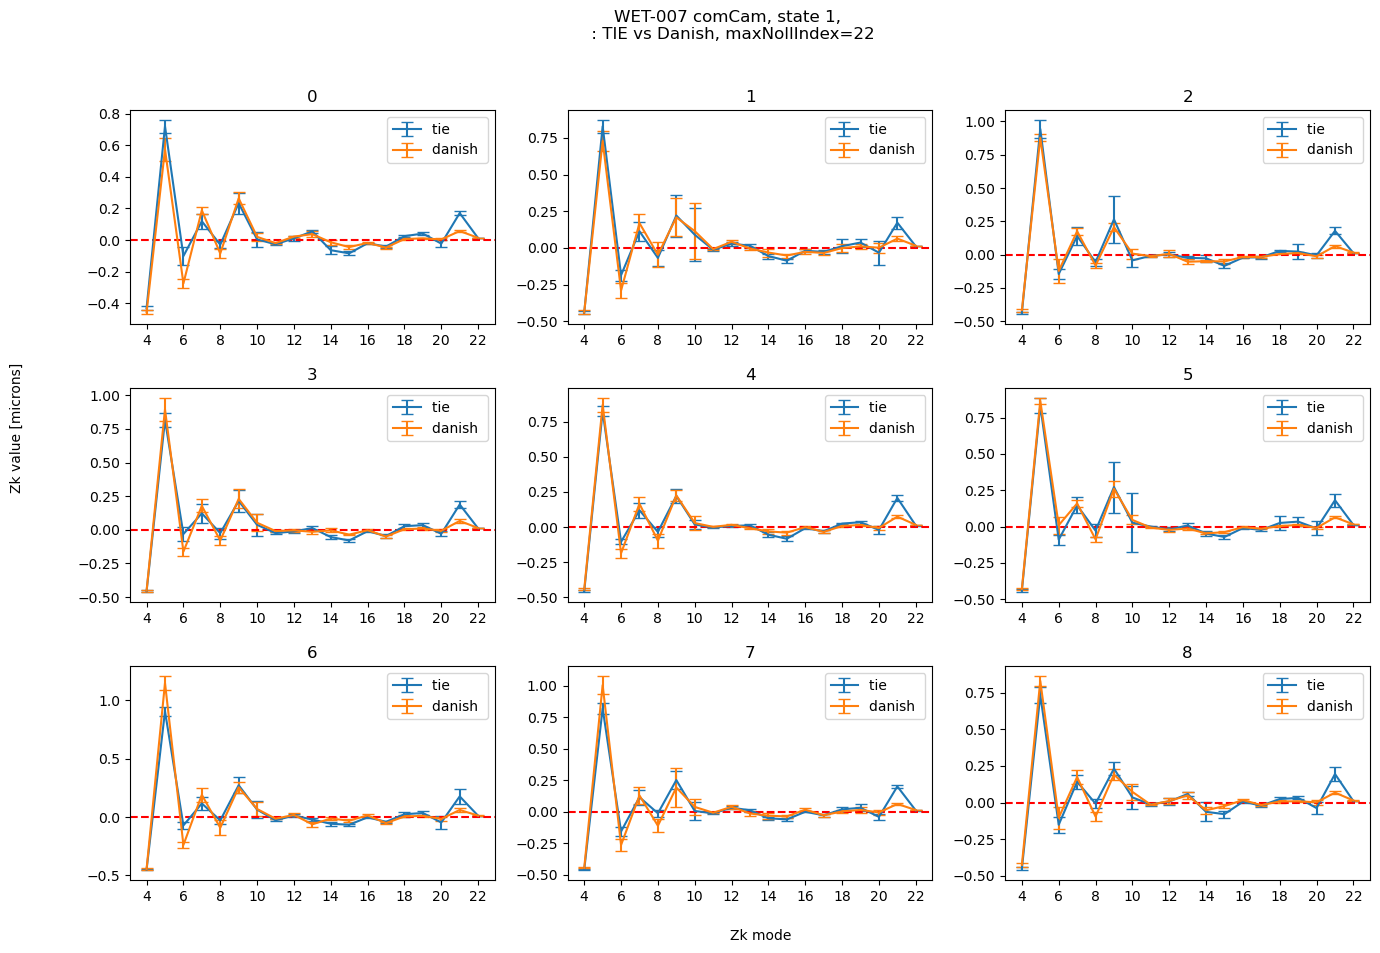

In [31]:
maxNollIndex = 22 
plot_fit_errorbar(1, results_stored[maxNollIndex], maxNollIndex, )

Illustrate the difference between the two methods:

In [6]:
def plot_diff(state, results, maxNollIndex):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        detId = i     
        ax[i].set_title(detId)
    
        # plot  difference for danish and tie
        zk1 = results['danish'][state][detId]['zernikeEstimateAvg'][0]
        zk2 = results['tie'][state][detId]['zernikeEstimateAvg'][0]
        minNoll = 4
        maxNoll = minNoll + len(zk1)
        ax[i].plot(np.arange(minNoll, maxNoll),zk1-zk2, marker='d', )
        ax[i].set_xticks(np.arange(minNoll, maxNoll,step=2))
        ax[i].axhline(0,ls='--', c='red')
        #ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, f'$\Delta$ zk fit (Danish-TIE) [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-007 comCam, state {state}, \n : TIE vs Danish, maxNollIndex={maxNollIndex}')

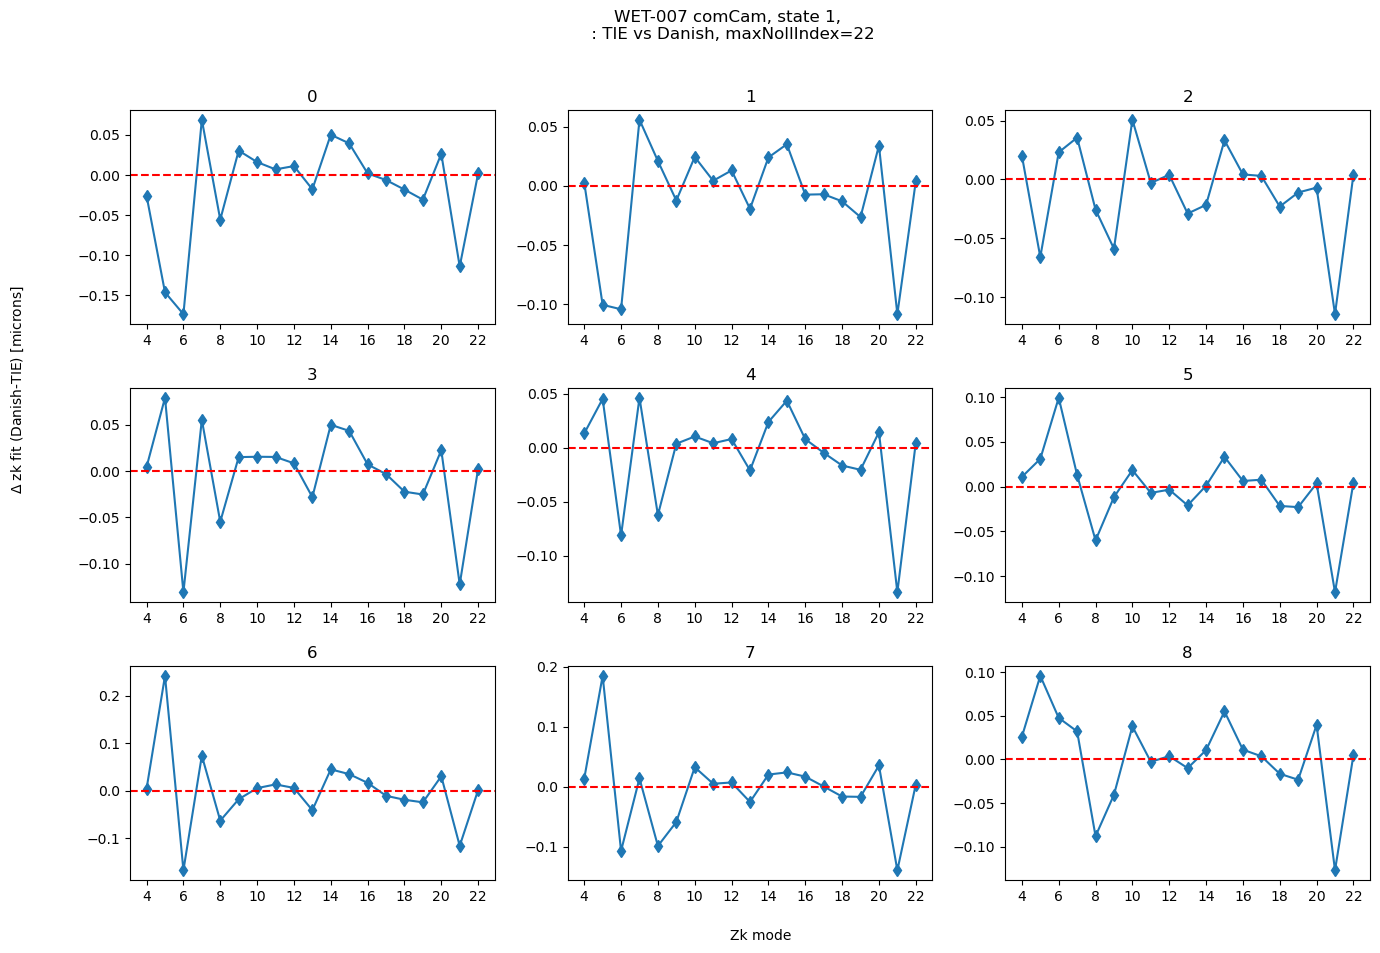

In [26]:
maxNollIndex = 22
plot_diff(1, results_stored[maxNollIndex], maxNollIndex)

Calculate the RMS difference between TIE and Danish per detector per state: 

In [27]:
def calc_rms_diff(results): 

    rmss={}
    states = {}
    rmserrDanish = {}
    rmserrTie = {}
    
    sumErrDanish  = {}
    sumErrTie = {}
    for raft in range(9):
       rmss[raft] = []
       states[raft] = [] 
       rmserrDanish[raft] = []
       rmserrTie[raft] = []
       sumErrDanish[raft] = []
       sumErrTie[raft]=[]
       for state in range(1,101):
            #print(raft, state)
            cond1 = len(results['danish'][state][raft])>1
            cond2 = len(results['tie'][state][raft])>1
            if cond1 and cond2 : 
                # calculate RMS difference between two estimates of Zk fits 
                zk1 = results['danish'][state][raft]['zernikeEstimateAvg'][0]
                zk2 = results['tie'][state][raft]['zernikeEstimateAvg'][0]
                rms_diff =  np.sqrt(np.mean(np.square(zk1-zk2)))
                rmss[raft].append(rms_diff)
                states[raft].append(state)
    
                # calculate RMS of uncertainties 
                for method, rmsDict, sumDict in zip(['danish', 'tie'],
                                           [rmserrDanish, rmserrTie],
                                            [sumErrDanish, sumErrTie]
                                          ):
                    zkRaw = results[method][state][raft]['zernikeEstimateRaw']
                    zks = results[method][state][raft]['zernikes']
                    mask_used = zks['used'][1:]
                    zkr_used = zkRaw[mask_used]
                    zkErr = np.std(zkr_used, axis=0) # uncertainty per Zk mode
                    rmsErr = np.sqrt(np.mean(np.square(zkErr))) # single number 
                    rmsDict[raft].append(rmsErr) 
                    sumDict[raft].append(np.sqrt(np.sum(np.square(zkErr)))) 
    
                if rms_diff > 10:
                    print(method, raft, state, rms_diff)
    return rmss, states, rmserrDanish, rmserrTie, sumErrDanish, sumErrTie

The total error per detector per state is the sum of variances. This is done for Danish and TIE:

$$
\sigma_{ttl}^{2} = \sum_{i=4}^{i=28}{\sigma_{i}^{2}}
$$

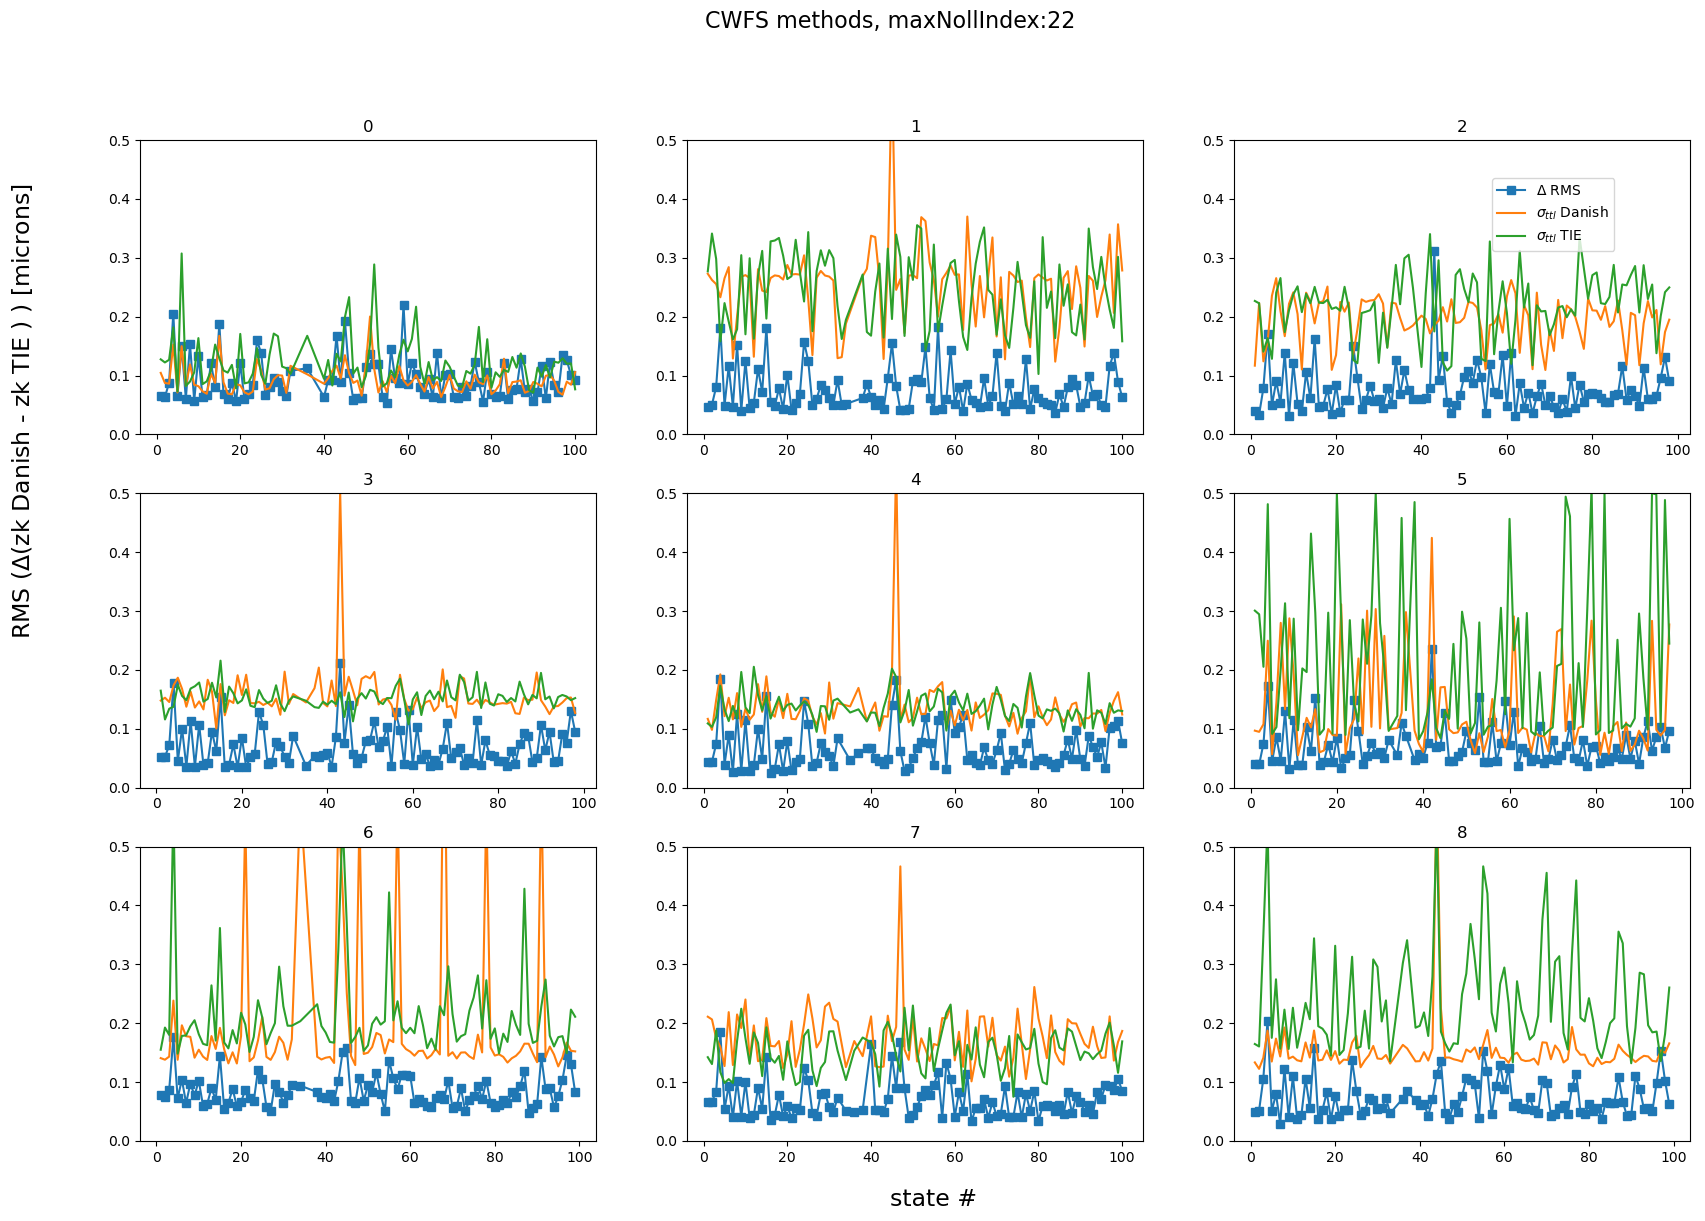

In [28]:
maxNollIndex = 22
rmss, states, rmserrDanish, rmserrTie, sumErrDanish, sumErrTie =  calc_rms_diff(results_stored[maxNollIndex])

fig,axs = plt.subplots(3,3,figsize=(20,13))
ax = np.ravel(axs)

for raft in range(9):
    ax[raft].plot(states[raft], rmss[raft], marker='s', label=r'$\Delta$ RMS')
    ax[raft].plot(states[raft], sumErrDanish[raft], label=r'$\sigma_{ttl}$ Danish') 
    ax[raft].plot(states[raft], sumErrTie[raft], label=r'$\sigma_{ttl}$ TIE') 
    ax[raft].set_title(raft)
    ax[raft].set_ylim(0,0.5)
   
fig.text(0.5,0.06,'state #', fontsize=17)
fig.text(0.06,0.5,r'RMS ($\Delta$(zk Danish - zk TIE ) ) [microns] ', rotation=90, fontsize=17)
fig.suptitle('CWFS methods, maxNollIndex:22', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

This means that the RMS difference between TIE and Danish is overall less than the combined variances. The difference between TIE and Danish is larger when using `maxNollIndex` of `29`:

tie 1 45 608.7696423542536


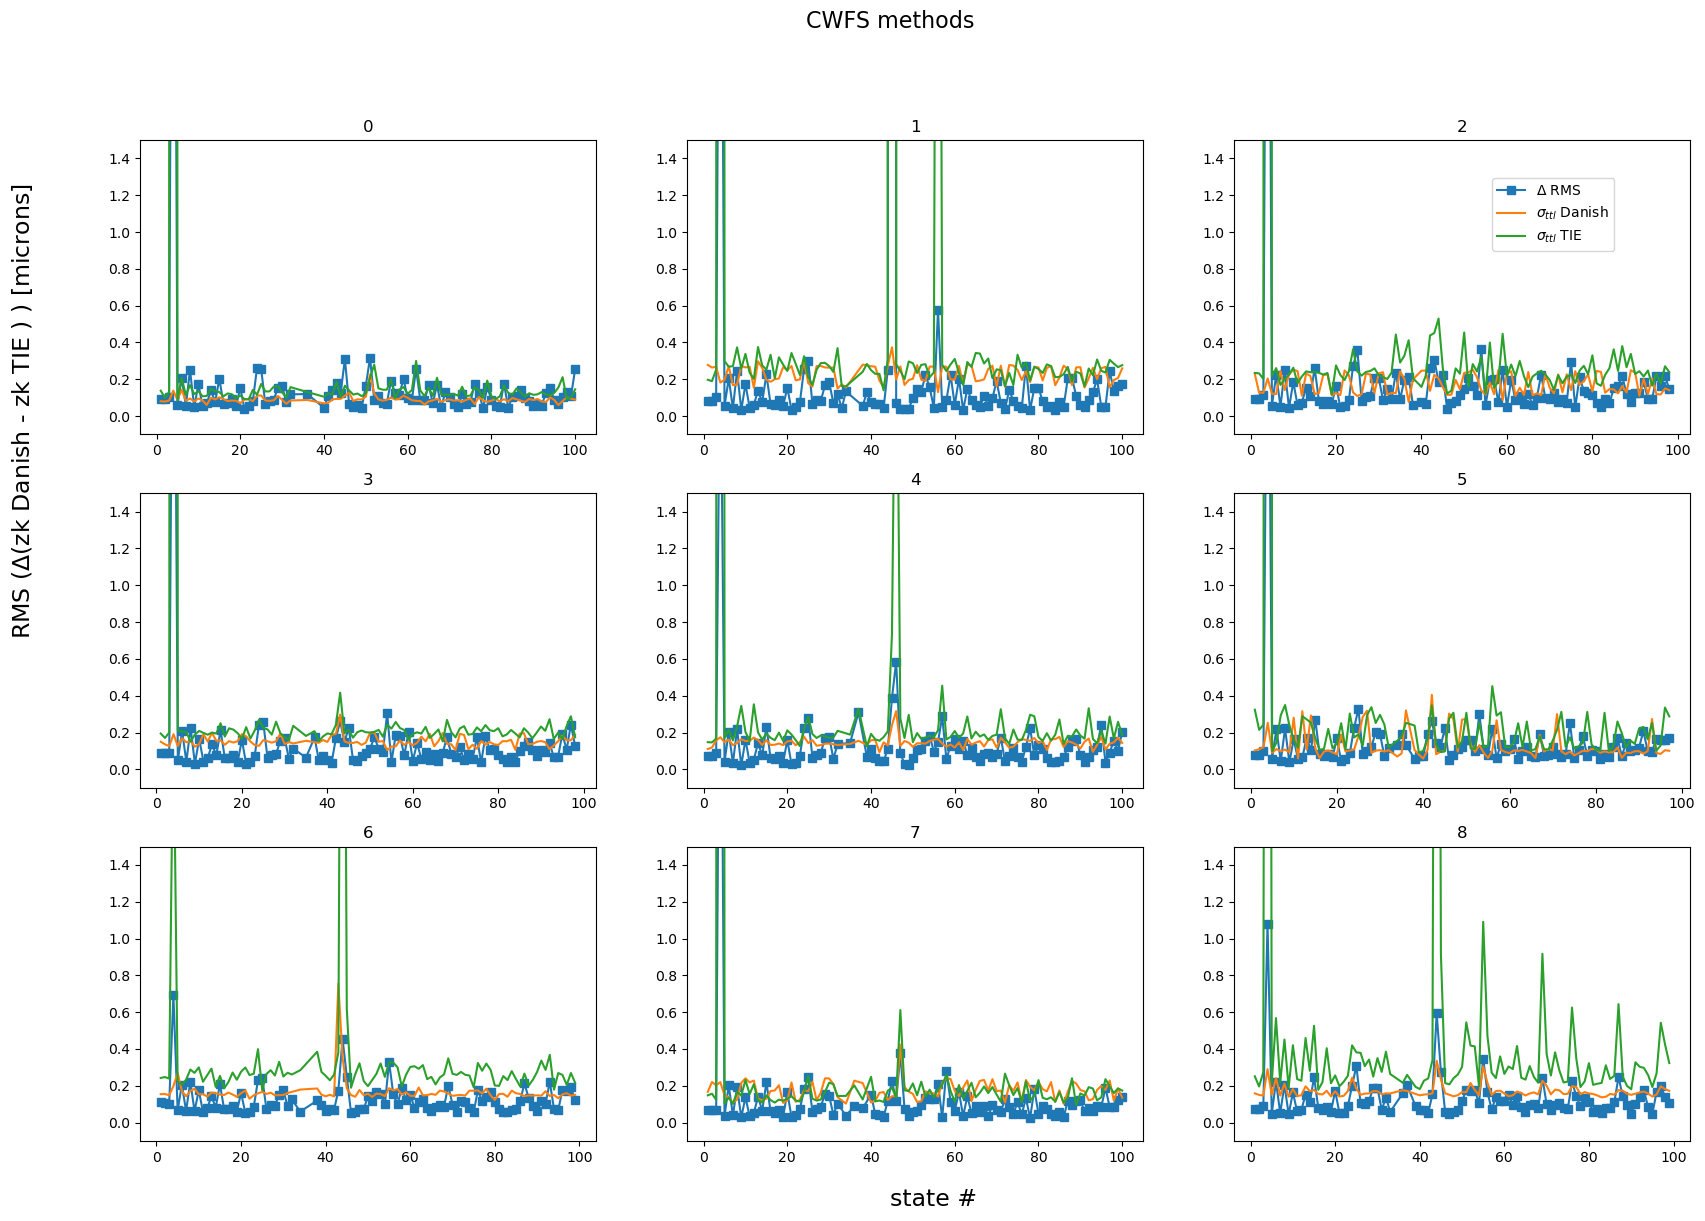

In [29]:
maxNollIndex= 29 
rmss, states, rmserrDanish, rmserrTie, sumErrDanish, sumErrTie =  calc_rms_diff(results_stored[maxNollIndex])
fig,axs = plt.subplots(3,3,figsize=(20,13))
ax = np.ravel(axs)

for raft in range(9):
    ax[raft].plot(states[raft], rmss[raft], marker='s', label=r'$\Delta$ RMS')
    ax[raft].plot(states[raft], sumErrDanish[raft], label=r'$\sigma_{ttl}$ Danish') 
    ax[raft].plot(states[raft], sumErrTie[raft], label=r'$\sigma_{ttl}$ TIE') 
    ax[raft].set_title(raft)
    ax[raft].set_ylim(-0.1,1.5)
   
fig.text(0.5,0.06,'state #', fontsize=17)
fig.text(0.06,0.5,r'RMS ($\Delta$(zk Danish - zk TIE ) ) [microns] ', rotation=90, fontsize=17)
fig.suptitle('CWFS methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

For most simulated states, the agreement is at 0.1 microns rms. Those which have a large TIE error (that also corresponds to largest difference in fit results), also correspond to cases where `maxNollIndex=29`  leads to unconstrained fit (i.e. fit stops at max iterations, and not because it converged). This situation is not seen with `maxNollIndex=22`. 

Plot in detail that state: with zk22 as max TIE is much better behaved than with zk28. 

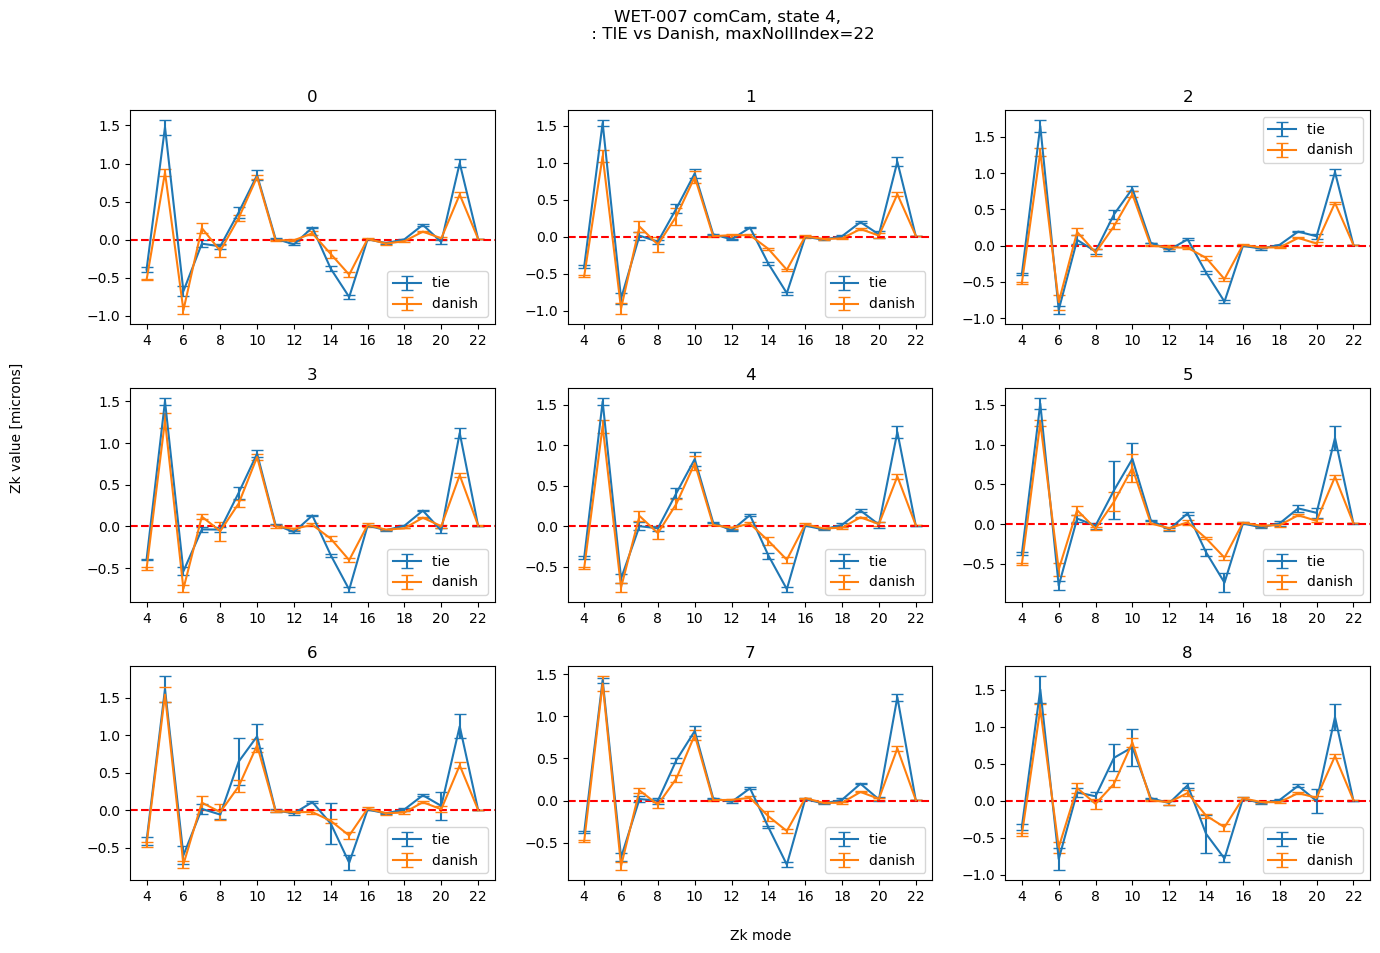

In [32]:
maxNollIndex = 22 
plot_fit_errorbar(4, results_stored[maxNollIndex], maxNollIndex, )

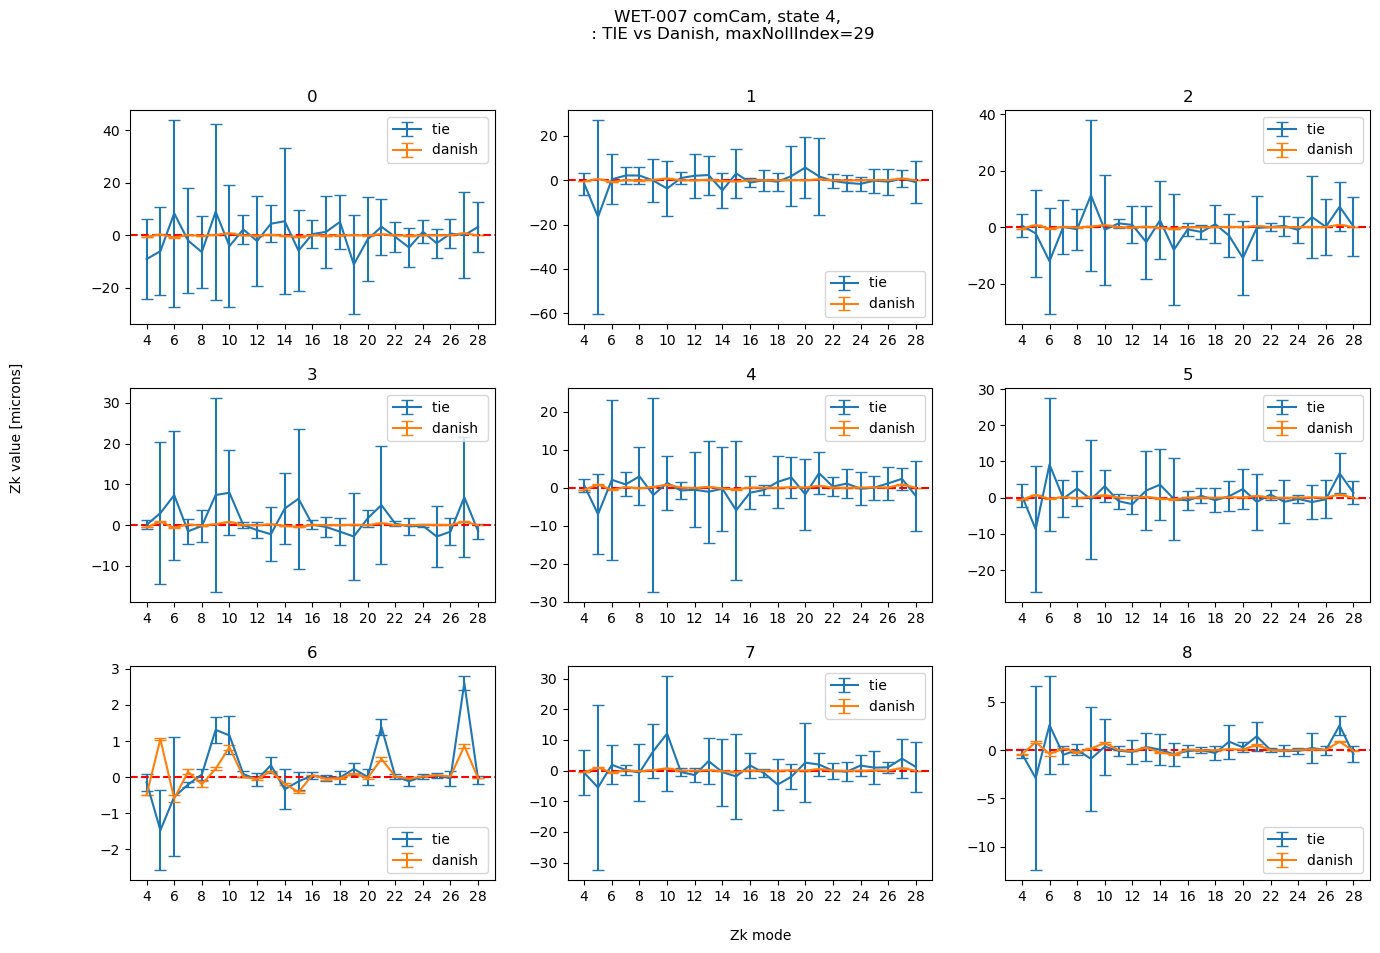

In [34]:
maxNollIndex = 29
plot_fit_errorbar(4, results_stored[maxNollIndex], maxNollIndex, )

In summary, based on the simulation of 100 random optical states fitted with either Danish or TIE, exploring the fit of Z4:22 or Z4:29. We find that across all states the RMS difference across all modes between Danish and TIE is < 0.1 microns. Danish performs well even with larger amount of allowed Zk modes, TIE suffers from unstable behavior, especially when adding Zk 23-26.  